In [143]:
import numpy

import warnings
warnings.filterwarnings("ignore", "Wswiglal-redir-stdio")
import lal

import pycbc.conversions
import pycbc
import pycbc.waveform, pycbc.filter, pycbc.types, pycbc.psd, pycbc.fft, pycbc.conversions
from pycbc import distributions

from tqdm import tqdm
import pandas as pd
from copy import copy

In [160]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
# PLOTTING OPTIONS
fig_width_pt = 3*246.0  # Get this from LaTeX using \showthe\columnwidth
inches_per_pt = 1.0/72.27               # Convert pt to inch
golden_mean = (np.sqrt(5)-1.0)/2.0         # Aesthetic ratio
fig_width = fig_width_pt*inches_per_pt  # width in inches
fig_height = fig_width*golden_mean      # height in inches
fig_size =  [fig_width,fig_height]

params = { 'axes.labelsize': 24,
          'font.family': 'serif',
          'font.serif': 'Computer Modern Raman',
          'font.size': 24,
          'legend.fontsize': 20,
          'xtick.labelsize': 24,
          'ytick.labelsize': 24,
          'axes.grid' : True,
          'text.usetex': True,
          'savefig.dpi' : 100,
          'lines.markersize' : 14,
          'figure.figsize': fig_size}

mpl.rcParams.update(params)

import seaborn as sns

In [145]:
class GenUniformWaveform(object):
    def __init__(self, buffer_length, sample_rate, f_lower):
        self.f_lower = f_lower
        self.delta_f = 1.0 / buffer_length
        tlen = int(buffer_length * sample_rate)
        self.flen = tlen // 2 + 1
        psd = pycbc.psd.read.from_txt('/work/yifanwang/ecc/templatebank/o3psd.txt', 
            self.flen, self.delta_f, self.f_lower, is_asd_file = False)
        self.kmin = int(f_lower * buffer_length)
        self.w = ((1.0 / psd[self.kmin:-1]) ** 0.5).astype(numpy.float32)
        qtilde = pycbc.types.zeros(tlen, numpy.complex64)
        q = pycbc.types.zeros(tlen, numpy.complex64)
        self.qtilde_view = qtilde[self.kmin:self.flen - 1]
        self.ifft = pycbc.fft.IFFT(qtilde, q)
        self.md = q._data[-100:]
        self.md2 = q._data[0:100]

    def generate(self, **kwds):  
        if kwds['approximant'] in pycbc.waveform.fd_approximants():  
            hp, hc = pycbc.waveform.get_fd_waveform(delta_f=self.delta_f,
                                                    **kwds)
            
            
            if 'fratio' in kwds:
                hp = hc * kwds['fratio'] + hp * (1 - kwds['fratio'])
                    
        else:
            dt = 1.0 / args.sample_rate
            hp = pycbc.waveform.get_waveform_filter(
                        pycbc.types.zeros(self.flen, dtype=numpy.complex64),
                        delta_f=self.delta_f, delta_t=dt,
                        f_lower=self.f_lower, **kwds)

        hp.resize(self.flen)
        hp = hp.astype(numpy.complex64)
        hp[self.kmin:-1] *= self.w
        s = float(1.0 / pycbc.filter.sigmasq(hp, low_frequency_cutoff=self.f_lower) ** 0.5)
        hp *= s
        hp.params = kwds
        hp.view = hp[self.kmin:-1]
        hp.s = (1.0 / s) ** 2.0
        return hp

    def match(self, hp, hc):
        pycbc.filter.correlate(hp.view, hc.view, self.qtilde_view)
        self.ifft.execute()
        m = max(abs(self.md).max(), abs(self.md2).max())
        return m * 4.0 * self.delta_f

# Newtonian estimate of the merger time
# Expression taken from Eq. (12) in https://arxiv.org/pdf/1911.06024
def tmerg(mass1, mass2, e, fmin):
    q = pycbc.conversions.q_from_mass1_mass2(mass1, mass2)
    Mtot = mass1 + mass2

    omega_start = numpy.pi * fmin * Mtot * lal.MTSUN_SI
    # Use Kepler 3rd law
    a0 = omega_start ** (-2 / 3.0)

    e2 = e * e
    e4 = e2 * e2

    f_e = (1.0 + (73.0 / 24) * e2 + (37.0 / 96.0) * e4) / (1 - e2) ** 3.5
    t_merger = 5 * ((1 + q) ** 2) * (a0**4.0) / (256 * q * f_e)
    t_merger_SI = t_merger * Mtot * lal.MTSUN_SI

    return t_merger_SI

# Generate a population of injections

In [174]:
inj = distributions.uniform.Uniform(
            mass1=(5,50),
            mass2=(5,50),
            spin1z=(-0.5,0.5),
            spin2z=(-0.5,0.5),
            eccentricity=(0,0.3),
            rel_anomaly=(0,2*np.pi)
            ).rvs(size=5000)

df = pd.DataFrame(inj)
df['match'] = np.nan
df['tmerg'] = np.nan
df['mchirp'] = pycbc.conversions.mchirp_from_mass1_mass2(df['mass1'],df['mass2'])


wf = GenUniformWaveform(buffer_length = 4, sample_rate = 2048, f_lower = 20)


p0 = {'approximant': 'SEOBNRv5E',
          'mass1': 20,
          'mass2': 20,
          'spin1z': 0.3,
          'spin2z': -0.3,
          'eccentricity': 0.1,
          'rel_anomaly': 1,
          'f_lower': 20}

h0 = wf.generate(**p0)
t0 = tmerg(p0['mass1'], p0['mass2'], p0['eccentricity'], 20)

In [175]:
p = copy(p0)

pkeys = ['mass1','mass2','spin1z','spin2z','eccentricity','rel_anomaly']

for i in tqdm(range(1000)):
    for pk in pkeys:
        p[pk] = df[pk][i]
    
    df.loc[i, 'tmerg'] = tmerg(p['mass1'],p['mass2'],p['eccentricity'], 20)
    try: # generate a waveform
        hnow = wf.generate(**p)
        df.loc[i, 'match'] = wf.match(h0,hnow)
    except ValueError:
        pass

100%|██████████| 1000/1000 [06:06<00:00,  2.73it/s]


Text(0, 0.5, 'Ecc')

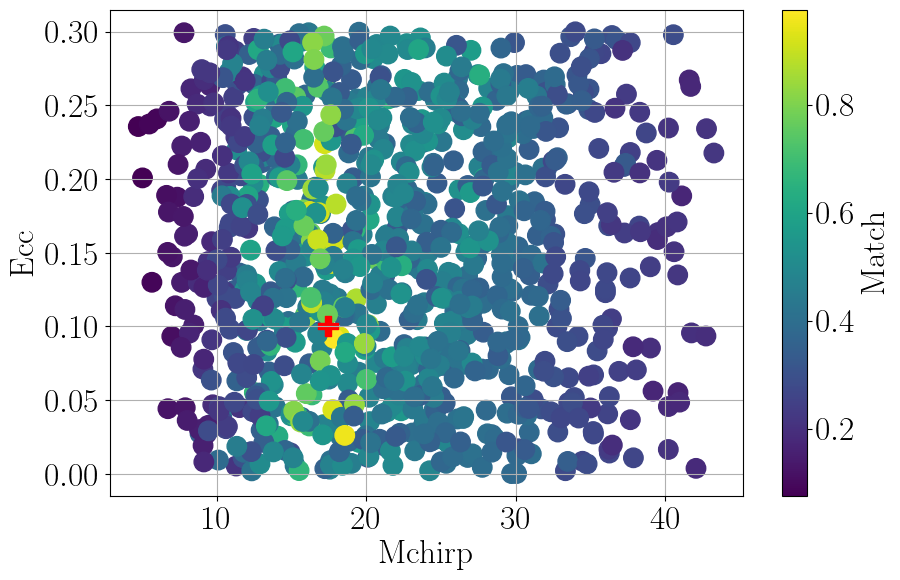

In [176]:
plt.scatter(df['mchirp'], df['eccentricity'],c=df['match'])
#plt.scatter(df['mchirp'], df['eccentricity'],c=df['tmerg']-t0,marker='x')
plt.colorbar(label='Match')

p0['mchirp'] = pycbc.conversions.mchirp_from_mass1_mass2(p0['mass1'],p0['mass2'])
plt.scatter(p0['mchirp'], p0['eccentricity'], marker='P',color='red')
plt.xlabel('Mchirp')
plt.ylabel('Ecc')

Text(0, 0.5, '$\\Delta t$')

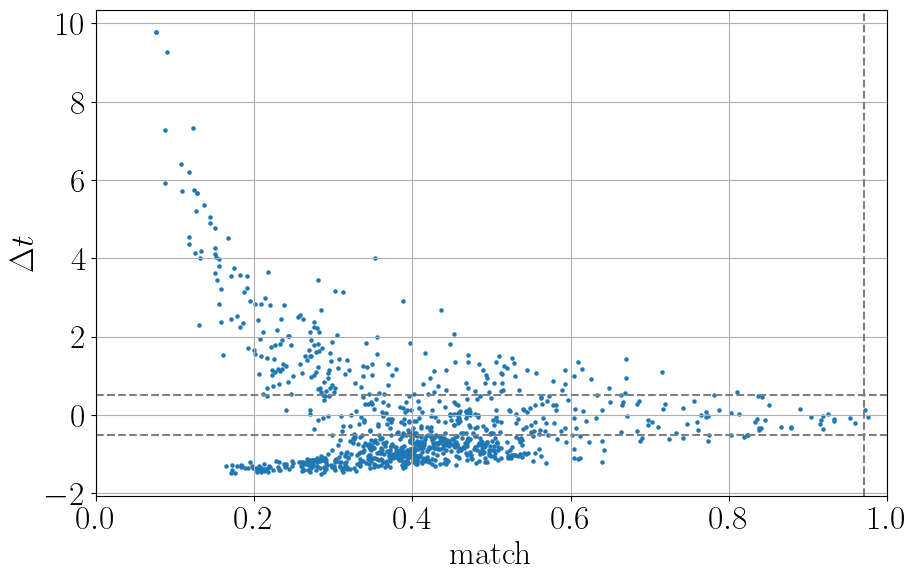

In [179]:
plt.scatter(df['match'],df['tmerg']-t0,s=5)
plt.axhline(y=0.5,ls='--',c='grey')
plt.axhline(y=-0.5,ls='--',c='grey')
plt.axvline(x=0.97,ls='--',c='grey')
plt.xlim(0,1)
plt.xlabel('match')
plt.ylabel('$\Delta t$')

In [ ]:
tmerg(30,30,0.5,20)

0.19551152236451552

In [ ]:
pycbc.conversions.tau0_from_mass1_mass2(30,30,20)

0.9549392747320128

In [ ]:
for m in numpy.linspace(1,50,10):
    print(m, tmerg(30,m,0,20))
    print(m, pycbc.conversions.tau0_from_mass1_mass2(30,m,20))

1.0 22.987963094630825
1.0 22.98796309463087
6.444444444444445 3.764768018957068
6.444444444444445 3.764768018957077
11.88888888888889 2.1376582338945
11.88888888888889 2.1376582338945034
17.333333333333336 1.5271681837135394
17.333333333333336 1.527168183713542
22.77777777777778 1.2050884991143667
22.77777777777778 1.205088499114368
28.22222222222222 1.0049666394432306
28.22222222222222 1.0049666394432324
33.66666666666667 0.8670155728623095
33.66666666666667 0.8679282914106343
39.111111111111114 0.7675388651201988
39.111111111111114 0.7678252638648471
44.55555555555556 0.6895895501983876
44.55555555555556 0.6912546519788512
50.0 0.6306280024554598
50.0 0.6306280024554612


In [ ]:
for m in numpy.linspace(1,50,10):
    print(m, tmerg(30,m,0,20))
    print(m, tmerg(30,m, 0.5, 20))

1.0 22.987963094630825
1.0 4.706489490603324
6.444444444444445 3.764768018957068
6.444444444444445 0.7707877832777377
11.88888888888889 2.1376582338945
11.88888888888889 0.43765800262120613
17.333333333333336 1.5271681837135394
17.333333333333336 0.312668024454516
22.77777777777778 1.2050884991143667
22.77777777777778 0.24672635557055583
28.22222222222222 1.0049666394432306
28.22222222222222 0.20575398122381863
33.66666666666667 0.8670155728623095
33.66666666666667 0.17751027635932495
39.111111111111114 0.7675388651201988
39.111111111111114 0.1571437011381644
44.55555555555556 0.6895895501983876
44.55555555555556 0.14118458244769977
50.0 0.6306280024554598
50.0 0.12911296463365296
